# Import

In [ ]:
import pandas as pd
import numpy as np
import torch

# Preprocessing

In [ ]:
import re
#from contractions import contractions_dict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Bỏ URLs
    url_pattern = re.compile(r'https?://\S+')
    text = url_pattern.sub(' ', text)

    # Bỏ HTML Tags
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(' ', text)

    # Mở rộng contractions
    #text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Bỏ punctuation và digits
    text = re.sub(r'[^\w\s]', ' ', text)

    # Bỏ emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U0001F1F2-\U0001F1F4"
        u"\U0001F1E6-\U0001F1FF"
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(' ', text)

    # Chuyển sang viết thường
    text = text.lower()

    # Tokenize và bỏ  stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    # Nối các token thành text
    text = ' '.join(tokens)

    return text


# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
nltk.download('punkt') #tokenization
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Preprocess

**Da preprocess**

In [ ]:
data = pd.read_csv('./data/train.csv')
data.head(5)

,text,label
0,dare finish book dare finish book simple inter...,0
1,amazon promoting hate stuff like hate jews hom...,0
2,herbie plays easy listening hh great fan disap...,0
3,freddie live 4ever long humans electricity con...,1
4,cord description 100 incorrect new original pa...,0


In [ ]:
test_df = pd.read_csv('./data/test.csv')
test_df

,text,label,preprocess_sentence
0,"Man, this is sick stuff!!!!: I set out on a mi...",0,man sick stuff set mission seek shocking films...
1,Still waiting for hardware: Ordered (1) chair ...,0,still waiting hardware ordered 1 chair 1 loves...
2,"OK Idea, Poorly Executed: Julia was good. Brad...",0,ok idea poorly executed julia good brad usual ...
3,Don't bother: This is a total waste of paper. ...,0,bother total waste paper save forrest print bo...
4,"Good, but disappointing: This was a good movie...",0,good disappointing good movie general however ...
...,...,...,...
995,no problemo: Our school has 100 of the LaCie P...,1,problemo school 100 lacie p3 xp never problem ...
996,Thank you Decapitated!: This album ironically ...,1,thank decapitated album ironically makes hope ...
997,Super item!: This vest came in handy for a my ...,1,super item vest came handy son birthday party ...
998,Great for the price: The car charger works as ...,1,great price car charger works expected ear bud...


# Prepare

In [ ]:
!pip install -q torchtext==0.16.0

In [ ]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [ ]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [ ]:
tokenizer

<function torchtext.data.utils._basic_english_normalize(line)>

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(data['text'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(data, test_size=0.05, random_state=42)


In [ ]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row['text']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df)
train_dataset = to_map_style_dataset(train_dataset)
val_dataset = prepare_dataset(val_df)
val_dataset = to_map_style_dataset(val_dataset)
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [ ]:
import torch

seq_length = 300

def collate_batch(batch):
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

# Train and Test

In [ ]:

import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

# Build TextCNN

In [ ]:
textCNN_param = {
    'vocab_size': 10000,
    'embed_dim': 256,
    'class_num': 2,
    "kernel_num": 16,
    "kernel_size": [3, 4, 5],
    "dropout": 0.5,
}

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class textCNN(nn.Module):
    def __init__(self, param):
        super(textCNN, self).__init__()
        ci = 1  # input chanel size
        kernel_num = param['kernel_num'] # output chanel size
        kernel_size = param['kernel_size']
        vocab_size = param['vocab_size']
        embed_dim = param['embed_dim']
        dropout = param['dropout']
        class_num = param['class_num']
        self.param = param
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=1)
        self.conv11 = nn.Conv2d(ci, kernel_num, (kernel_size[0], embed_dim))
        self.conv12 = nn.Conv2d(ci, kernel_num, (kernel_size[1], embed_dim))
        self.conv13 = nn.Conv2d(ci, kernel_num, (kernel_size[2], embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(kernel_size) * kernel_num, class_num)

    def init_embed(self, embed_matrix):
        self.embed.weight = nn.Parameter(torch.Tensor(embed_matrix))

    @staticmethod
    def conv_and_pool(x, conv):
        # x: (batch, 1, sentence_length,  )
        x = conv(x)
        # x: (batch, kernel_num, H_out, 1)
        x = F.relu(x.squeeze(3))
        # x: (batch, kernel_num, H_out)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        #  (batch, kernel_num)
        return x

    def forward(self, x):
        # x: (batch, sentence_length)
        x = self.embed(x)
        # x: (batch, sentence_length, embed_dim)
        # TODO init embed matrix with pre-trained
        x = x.unsqueeze(1)
        # x: (batch, 1, sentence_length, embed_dim)
        x1 = self.conv_and_pool(x, self.conv11)  # (batch, kernel_num)
        x2 = self.conv_and_pool(x, self.conv12)  # (batch, kernel_num)
        x3 = self.conv_and_pool(x, self.conv13)  # (batch, kernel_num)
        x = torch.cat((x1, x2, x3), 1)  # (batch, 3 * kernel_num)
        x = self.dropout(x)
        logit = F.log_softmax(self.fc1(x), dim=1)
        return logit

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [ ]:
model =textCNN(textCNN_param)

In [ ]:
model

textCNN(
  (embed): Embedding(10000, 256, padding_idx=1)
  (conv11): Conv2d(1, 16, kernel_size=(3, 256), stride=(1, 1))
  (conv12): Conv2d(1, 16, kernel_size=(4, 256), stride=(1, 1))
  (conv13): Conv2d(1, 16, kernel_size=(5, 256), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=48, out_features=2, bias=True)
)

In [ ]:
import torch.optim as optim
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = textCNN(textCNN_param)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model_TextCNN'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

save_path = os.path.join(save_model, f"{model_name}.pt")
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

| epoch   1 |    50/  293 batches | accuracy    0.506
| epoch   1 |   100/  293 batches | accuracy    0.510
| epoch   1 |   150/  293 batches | accuracy    0.511
| epoch   1 |   200/  293 batches | accuracy    0.527
| epoch   1 |   250/  293 batches | accuracy    0.527
-----------------------------------------------------------
| End of epoch   1 | Time:  6.95s | Train Accuracy    0.536 | Train Loss    0.767 | Valid Accuracy    0.622 | Valid Loss    0.658 
-----------------------------------------------------------
| epoch   2 |    50/  293 batches | accuracy    0.551
| epoch   2 |   100/  293 batches | accuracy    0.558
| epoch   2 |   150/  293 batches | accuracy    0.555
| epoch   2 |   200/  293 batches | accuracy    0.564
| epoch   2 |   250/  293 batches | accuracy    0.578
-----------------------------------------------------------
| End of epoch   2 | Time:  6.37s | Train Accuracy    0.590 | Train Loss    0.707 | Valid Accuracy    0.692 | Valid Loss    0.620 
------------------

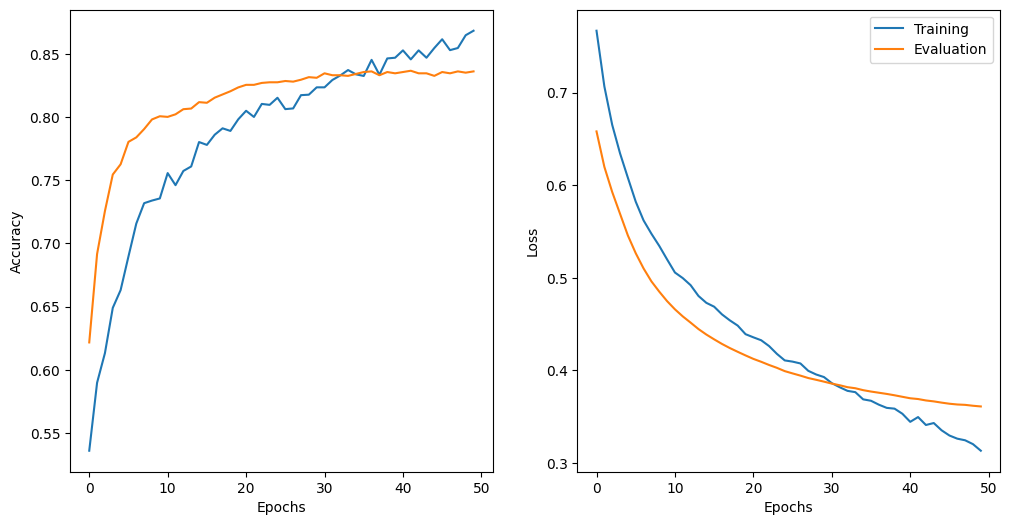

In [ ]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)